# Brown Dwarf Climate Model with Moist Adiabat

In this tutorial we will test another parameter space using a moist adiabt which takes into consideration water latent heat release. You can read more details about the effects of this in [Tang et al. 2021](https://iopscience.iop.org/article/10.3847/1538-4357/ac1e90) for clear and partly cloudy atmospheres, and [Mang et al. 2024](https://iopscience.iop.org/article/10.3847/1538-4357/ad6c4c) for fully cloudy atmospheres. 

Here we're just going to test running the model for a clear atmosphere

What you should already be familiar with: 
[basics of running/analyzing thermal spectra](https://natashabatalha.github.io/picaso/tutorials.html#basics-of-thermal-emission)

In [ ]:
import sys
import os

import warnings
warnings.filterwarnings('ignore')
import picaso.justdoit as jdi
import picaso.justplotit as jpi
jpi.output_notebook()
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Loading BokehJS ...

In [2]:
cl_run = jdi.inputs(calculation="browndwarf", climate = True) # start a calculation 

#note you need to put the climate keyword to be True in order to do so
# now you need to add these parameters to your calculation  

teff= 350 # Effective Temperature of your Brown Dwarf in K
grav = 100 # Gravity of your brown dwarf in m/s/s

cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity
cl_run.effective_temp(teff) # input effective temperature

In [ ]:
# Here we're going to run a higher metallicity model since the effect of the latent heat is more pronounced at higher metallicities

mh = '+100' #log metallicity
CtoO = '100'# CtoO ratio relative to solar

# ck_db = f'/Users/nbatalh1/Documents/data/kcoeff_asci/sonora_2020_feh{mh}_co_{CtoO}.data.196'

# sonora_profile_db = '/Users/nbatalh1/Documents/data/sonora_bobcat/structures_m+0.0/'

ck_db = os.path.join(os.getenv('picaso_refdata'),'opacities', 'preweighted', f'sonora_2020_feh{mh}_co_{CtoO}.data.196') # recommended download #1 above
sonora_profile_db = os.path.join(os.getenv('picaso_refdata'),'sonora_grids','bobcat', 'structures_m+0.0')

# and not the line by line opacities
opacity_ck = jdi.opannection(ck_db=ck_db,method='preweighted') # grab your opacities

In [4]:
nlevel = 91 # number of plane-parallel levels in your code

# let's start with a Sonora Bobcat profile
pressure_bobcat,temp_bobcat = np.loadtxt(jdi.os.path.join(
                            sonora_profile_db,f"t{teff}g{grav}nc_m0.0.dat"),
                            usecols=[1,2],unpack=True, skiprows = 1)

In [ ]:
nofczns = 1 # number of convective zones initially. Let's not play with this for now.

nstr_upper = 40 # top most level of guessed convective zone
nstr_deep = nlevel -2 # this is always the case. Dont change this
nstr = np.array([0,nstr_upper,nstr_deep,0,0,0]) # initial guess of convective zones

# Here are some other parameters needed for the code.
rfacv = 0.0 #we are focused on a brown dwarf so let's keep this as is

Now we would use the inputs_climate function to input everything together to our cl_run we started. Here we'll make sure to set `moistgrad = True`

In [6]:
cl_run.inputs_climate(temp_guess=temp_bobcat, pressure=pressure_bobcat, 
                      nstr=nstr, nofczns=nofczns , rfacv=rfacv, moistgrad=True)

In [7]:
out = cl_run.climate(opacity_ck, save_all_profiles=True, with_spec=True)

SUMMARY
-------
Clouds: False
quench False
cold_trap False
vol_rainout False
no_ph3 False
Moist Adiabat: True
Iteration number  0 , min , max temp  95.07823516247886 2252.7992338578224 , flux balance  -0.6225257907955635
Iteration number  1 , min , max temp  96.23785559079282 2269.7268554450548 , flux balance  -0.6152190408842285
Iteration number  2 , min , max temp  96.77310916392098 2287.6838601153217 , flux balance  -0.6070723852639355
Iteration number  3 , min , max temp  96.9475115514265 2306.889389994422 , flux balance  -0.5981310417397278
Iteration number  4 , min , max temp  97.15353862621551 2326.688411427188 , flux balance  -0.5884754086643926
Iteration number  5 , min , max temp  97.39171413320106 2346.7825462268993 , flux balance  -0.578169067333616
Iteration number  6 , min , max temp  97.66269225304569 2367.0813423850327 , flux balance  -0.5672546899562859
Iteration number  7 , min , max temp  97.44429246971347 2387.360226973886 , flux balance  -0.5557600096516255
Iterati

Now let's compare the PT profile with the one generated in Tang et al. 2021 to benchmark our model

Text(0.5, 1.0, 'T$_{\\rm eff}$= 350 K, log(g)=4.0')

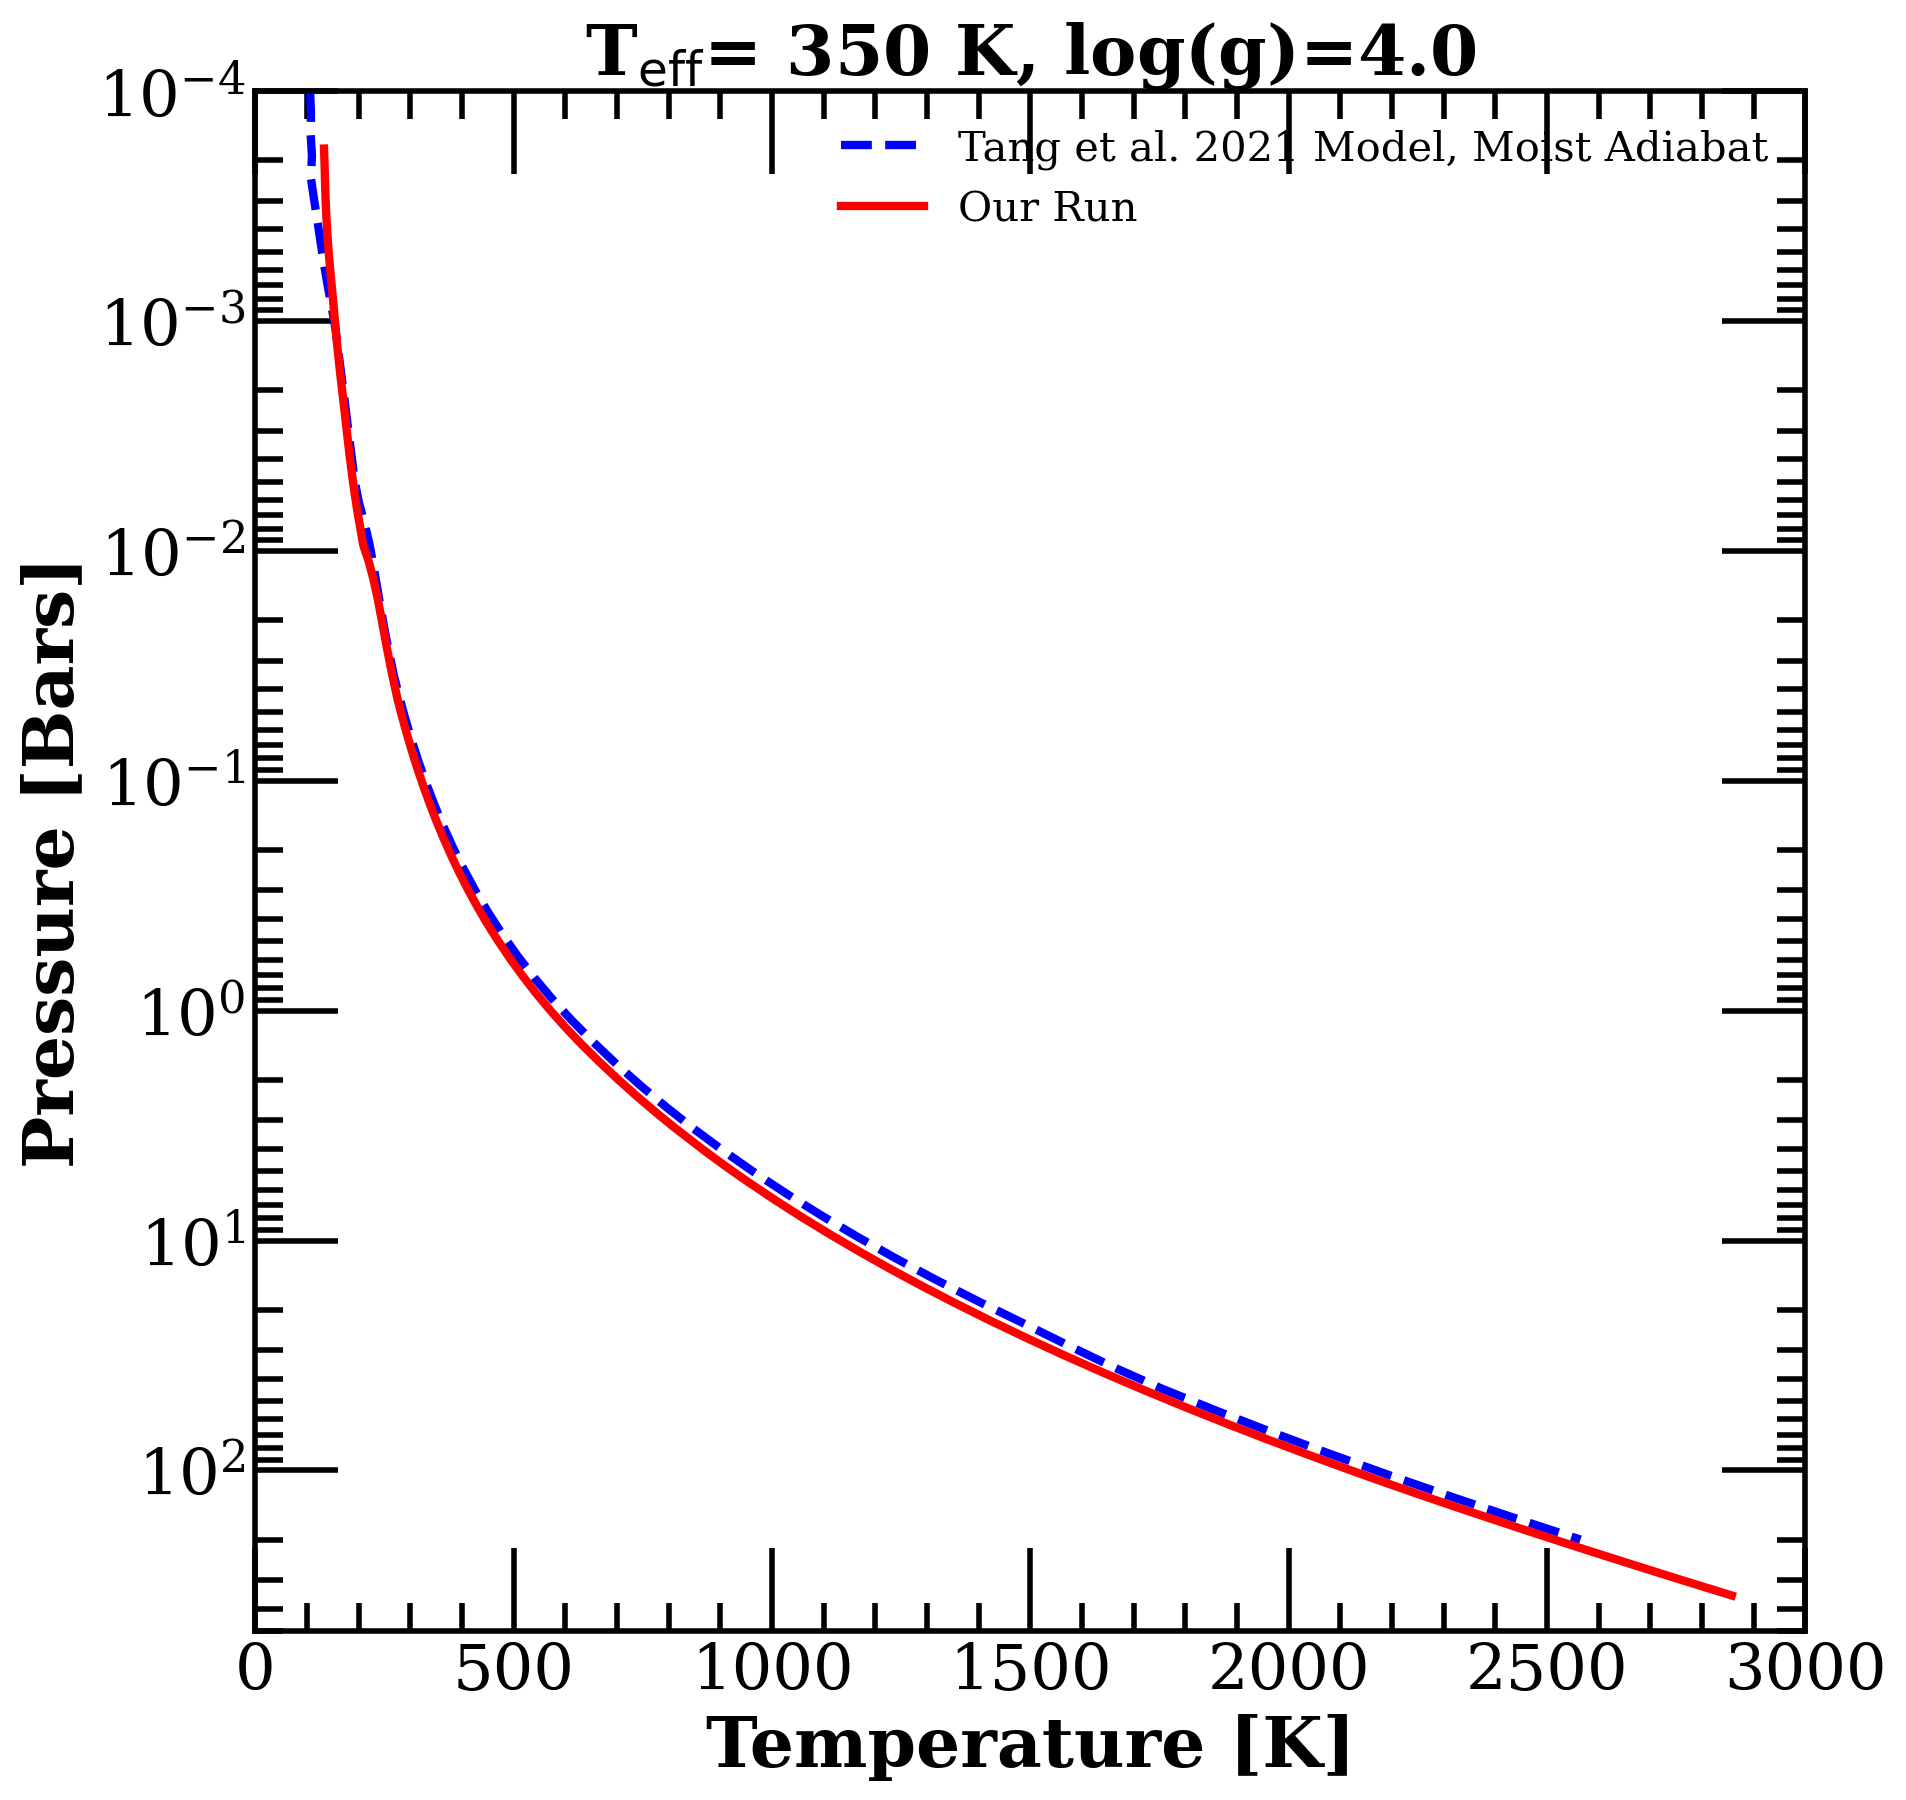

In [8]:
# pressure_bobcat,temp_bobcat = np.loadtxt(jdi.os.path.join(
#                             sonora_profile_db,f"t{teff}g{grav}nc_m0.0.dat"),
#                             usecols=[1,2],unpack=True, skiprows = 1)

pressure_tang, temp_tang = np.loadtxt("t350g100nc_m1.0.cmp.gz",
                            usecols=[1,3],unpack=True, skiprows = 1)

plt.figure(figsize=(10,10))
plt.ylabel("Pressure [Bars]", fontsize=25)
plt.xlabel('Temperature [K]', fontsize=25)
plt.ylim(500,1e-4)
plt.xlim(0,3000)

# plt.semilogy(temp_bobcat,pressure_bobcat,color="k",linestyle="--",linewidth=3,label="Sonora Bobcat, Dry Adiabat ")
plt.semilogy(temp_tang,pressure_tang,color="b",linestyle="--",linewidth=3,label="Tang et al. 2021 Model, Moist Adiabat")

plt.semilogy(out['temperature'],out['pressure'],color="r",linewidth=3,label="Our Run")

plt.minorticks_on()
plt.tick_params(axis='both',which='major',length =30, width=2,direction='in',labelsize=23)
plt.tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=23)

plt.legend(fontsize=15)

plt.title(r"T$_{\rm eff}$= 350 K, log(g)=4.0",fontsize=25)

Overall it looks pretty good! Slight differences are likely due to the difference in the number of layers used (Tang 2021 models use 68 layers and we have 91) as well as the fact that we're using updated ck tables.